In [43]:
# %pip install xgboost
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [44]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
df = pd.read_csv(path + "/heart.csv")
# print("Path to dataset files:", path)
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [45]:
cat_variables = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] #Categorical variables to be one hot encoded, rest are numerical. You may wonder why I don't take Cholestorl, RestingBP, those are unstable and regression needed.
# df = pd.get_dummies(df, columns = cat_variables, prefix = cat_variables, drop_first=True) # Already encoded in previous cell.
# Not only that we drop first column to avoid dummy variable trap, which is multicollinearity.
#So, the command for that is: pd.get_dummies(variable, columns = whichever columns you want to encode, drop_first = True to avoid dummy variable trap)
df.head()
# As you can see now that Sex_M, is considered true false, while ChestPainType_ASY, NAP, TA are the 3 new columns created for ChestPainType. RestingECG_ST, LVH are the 2 new columns created for RestingECG. ExerciseAngina_Y is the new column created for ExerciseAngina. ST_Slope_Flat, Up are the 2 new columns created for ST_Slope.


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [46]:
features = [x for x in df.columns if x not in 'HeartDisease'] #Features will take all of the columns except HeartDisease, which is the target variable.
print(len(features))    


11


In [47]:
help(train_test_split) #Help function automatically splits data into training and testing sets. By default it is 75% training and 25% testing, but you can change that using test_size parameter. random_state is used to ensure that the split is always the same, so that results are reproducible.
#However, you may ask where is cross validation sets? Well, it is already split too. 
#So, if you want to do cross validation, you can use cross_val_score function from sk
#learn.model_selection module. It will automatically split the training set into k folds, train the model on k-1 folds and test it on the remaining fold. It will do this k times and return the average accuracy score. You can change the number of folds using cv parameter. By default it is 5.


Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None
)
    Split arrays or matrices into random train and test subsets.

    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.

    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value

In [48]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size = 0.8, random_state = 42) #80% training, 20% testing, in a random of 42 numbers that can be chosen
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
validation samples: 184
target proportion: 0.5463


In [49]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
          ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]
#So what does this do?
# min_samples_split: The minimum number of samples required to split an internal node. If the number of samples is less than this number, then the node will not be split. This is used to control overfitting. The default value is 2.
# max_depth: The maximum depth of the tree. If the depth of the tree is greater than this number, then the node will not be split. This is used to control overfitting. The default value is None, which means that the tree will be expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# n_estimators: The number of trees in the forest. The default value is 100.

In [50]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=42,).fit(X_train, y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    accuracy_train = accuracy_score(y_train, prediction_train)
    accuracy_val = accuracy_score(y_val, prediction_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])


#First up, the random forest classifier.
# It is an ensemble of decision trees, where each tree is trained on a random subset of the data and a random subset of the features.
# The final prediction is made by averaging the predictions of all the trees.
# The main hyperparameters to tune are:
# min_samples_split: The minimum number of samples required to split an internal node. This is basically normal decision tree hyperparameter. 
# In order to split a node, it must have at least this many samples. 
# Which you already  had known from decision trees.
# On the other hand, if you set it too high, it may confront overfitting.
# max_depth: The maximum depth of the tree. This is also a normal decision tree hyperparameter.
# In order to limit the depth of the tree, you can set this parameter.
# If you set it too low, it may underfit the data. If you set it too high, it may overfit the data.
# n_estimators: The number of trees in the forest. The more trees, the better the performance, but also the more computationally expensive.
# Now, let's summarize all of the knowledge we have learned so far.
# Decision trees are simple and interpretable, but they can easily overfit the data.
# Random forests are an ensemble of decision trees, which can reduce overfitting and improve performance
# And, they are also less interpretable than decision trees.
# Decision trees are prone to high variance, while random forests are less prone to high variance.
# However, decision trees are more prone to high bias, while random forests are less prone to high bias.
# Finally, random forests are more computationally expensive than decision trees.
# But, decision trees. How does it work?
# Decision trees work by recursively splitting the data into subsets based on the values of the features.
# The goal is to create subsets that are as pure as possible, meaning that they contain only one class of the target variable.
# The splitting is done using a criterion, such as Gini impurity or information gain. Information gain = Entropy(parent) - [weight * Entropy(children left)] - [weight * Entropy(children right)]
# The process continues until a stopping criterion is met, such as a maximum depth or a minimum number of samples in a node.


ValueError: could not convert string to float: 'M'

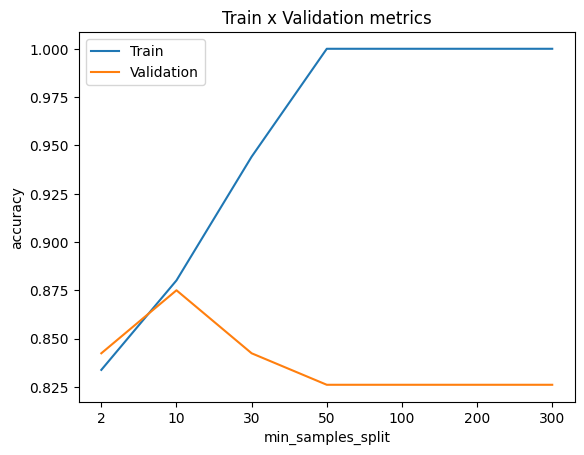

In [ ]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth = max_depth, random_state=42,).fit(X_train, y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    accuracy_train = accuracy_score(y_train, prediction_train)
    accuracy_val = accuracy_score(y_val, prediction_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
    # accuracy_list_train.append(accuracy_train)
    # accuracy_list_val.append(accuracy_val)
plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

# Decision tree classifer tends to split nodes, and it does it based on infomration gain or gini impurity.
# The main hyperparameters to tune are:
# max_depth: The maximum depth of the tree. This is used to control overfitting. If the depth is too high, the model may overfit the data. If the depth is too low, the model may underfit the data.
# min_samples_split: The minimum number of samples required to split an internal node. This is
# used to control overfitting. If the number is too high, the model may underfit the data. If the number is too low, the model may overfit the data
# min_samples_leaf: The minimum number of samples required to be at a leaf node. This is used to control overfitting. If the number is too high, the model may underfit the data. If the number is too low, the model may overfit the data.
# Now, let's summarize all of the knowledge we have learned so far.
# Decision trees are simple and interpretable, but they can easily overfit the data.
# Highest calculation of information gain or lowest gini impurity is used to split the nodes.
# You may wonder why we don't use min_samples_leaf, well it is because it is not as important as the other two hyperparameters.
# It is also not as commonly used as the other two hyperparameters.
# Not only that min_samples_split is more important than min_samples_leaf, because it controls the splitting of the nodes, while min_samples_leaf only controls the leaf nodes.
# But all of these is in decision trees. But max_depth_list and min_samples_split_list which is more valued? In terms of decision tree
# They both have value whereas they keep min_samples split constant and vary max_depth, and vice versa.
# Both have value, but max_depth is more important than min_samples_split.
# But in random forest, min_samples_split is more important than max_depth.
# This is because random forest is an ensemble of decision trees, and each tree is trained on a random subset of the data and a random subset of the features.
# If we are not smart on picking subset of data and features, then it may lead to overfitting.
#  So, min_samples_split is more important than max_depth in random forest.
# Max_depth in decision_tree is more important than min_samples_split because it controls the depth of the tree, which is more important than the number of samples required to split an internal node.
# When to use decision trees vs random forests?
# If you have a small dataset, then decision trees are a good choice because they are simple and interpretable.
# If you have a large dataset, then random forests are a better choice because they can reduce overfitting and improve performance.
# If you need interpretability, then decision trees are a better choice because they are more interpretable than random forests.
# If you need performance, then random forests are a better choice because they can improve performance compared to decision trees.
# Decision trees vs random forests vs neural networks?
# If you have a small dataset, then decision trees are a good choice because they are simple and interpretable.
# If you have a large dataset, then random forests are a better choice because they can reduce overfitting and improve performance.
# If you have a very large dataset, then neural networks are a better choice because they can learn complex patterns in the data.
# If you need interpretability, then decision trees are a better choice because they are more interpretable than random forests and neural networks.
# If you need performance, then neural networks are a better choice because they can improve performance compared
# to decision trees and random forests.
# However, neural networks are more complex and less interpretable than decision trees and random forests.
# Finally, neural networks are more computationally expensive than decision trees and random forests.
# But, decision trees and random forests are more computationally expensive than linear models.
# But, linear models are more computationally expensive than simple models like logistic regression and naive bayes.
# But, logistic regression and naive bayes are more computationally expensive than simple models like decision trees and random forests.
# But, decision trees and random forests are more computationally expensive than simple models like logistic regression and naive bayes.


In [ ]:
decision_tree_model = DecisionTreeClassifier(max_depth=4, min_samples_split=50, random_state=42)
decision_tree_model.fit(X_train, y_train)
y_pred = decision_tree_model.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.8586956521739131


In [ ]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]
# Now, let's move to XGBoost.
# XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
# It is an ensemble of decision trees, where each tree is trained on the residuals of the previous tree.
# The final prediction is made by summing the predictions of all the trees.
# The main hyperparameters to tune are:
# learning_rate: The step size at each iteration while moving toward a minimum of a loss function. It is used to control overfitting. If the learning rate is too high, the model may overfit the data. If the learning rate is too low, the model may underfit the data.
# max_depth: The maximum depth of the tree. This is used to control overfitting. If the depth is too high, the model may overfit the data. If the depth is too low, the model may underfit the data.
# n_estimators: The number of trees in the forest. The default value is 100.
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=4, learning_rate=0.1, n_estimators=500, random_state=42, verbosity=1)
#XGBClassifer for the XGBOOST, an gradient boosted version of random forest or decision tree.
# use_label_encoder=False is used to avoid warning message.
# eval_metric='logloss' is used to specify the evaluation metric. In this case, we are using log loss.
# max_depth=4 is used to specify the maximum depth of the tree.
# learning_rate=0.1 is used to specify the learning rate.
# n_estimators=100 is used to specify the number of trees in the forest.
# verbosity=1 is used to specify the verbosity level. The default value is 1.
# What is verbosity? It is used to control the amount of information printed during training. The higher the value, the more information is printed.
# The default value is 1, which means that only warnings and errors are printed. If you set it to 0, then nothing is printed. If you set it to 2, then more information is printed, such as the training progress and the evaluation metrics.
# Finally, random_state=42 is used to specify the random seed.
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.65421
[1]	validation_0-logloss:0.61419
[2]	validation_0-logloss:0.58330
[3]	validation_0-logloss:0.55544
[4]	validation_0-logloss:0.53387
[5]	validation_0-logloss:0.51495
[6]	validation_0-logloss:0.50101
[7]	validation_0-logloss:0.48558
[8]	validation_0-logloss:0.46927
[9]	validation_0-logloss:0.45986
[10]	validation_0-logloss:0.44828
[11]	validation_0-logloss:0.43864
[12]	validation_0-logloss:0.43279
[13]	validation_0-logloss:0.42564
[14]	validation_0-logloss:0.42299
[15]	validation_0-logloss:0.41812
[16]	validation_0-logloss:0.41323
[17]	validation_0-logloss:0.41081
[18]	validation_0-logloss:0.40962
[19]	validation_0-logloss:0.40664
[20]	validation_0-logloss:0.40283
[21]	validation_0-logloss:0.39984
[22]	validation_0-logloss:0.39552
[23]	validation_0-logloss:0.39349
[24]	validation_0-logloss:0.38919
[25]	validation_0-logloss:0.38980
[26]	validation_0-logloss:0.38798
[27]	validation_0-logloss:0.38507
[28]	validation_0-logloss:0.38217
[29]	validation_0-loglos

c:\Users\vpthi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:17:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[93]	validation_0-logloss:0.37370
[94]	validation_0-logloss:0.37393
[95]	validation_0-logloss:0.37617
[96]	validation_0-logloss:0.37632
[97]	validation_0-logloss:0.37684
[98]	validation_0-logloss:0.37669
[99]	validation_0-logloss:0.37696
[100]	validation_0-logloss:0.37680
[101]	validation_0-logloss:0.37763
[102]	validation_0-logloss:0.37739
[103]	validation_0-logloss:0.37713
[104]	validation_0-logloss:0.37806
[105]	validation_0-logloss:0.37904
[106]	validation_0-logloss:0.37927
[107]	validation_0-logloss:0.37986
[108]	validation_0-logloss:0.37881
[109]	validation_0-logloss:0.37843
[110]	validation_0-logloss:0.37867
[111]	validation_0-logloss:0.38036
[112]	validation_0-logloss:0.38037
[113]	validation_0-logloss:0.38051
[114]	validation_0-logloss:0.38199
[115]	validation_0-logloss:0.38129
[116]	validation_0-logloss:0.38308
[117]	validation_0-logloss:0.38350
[118]	validation_0-logloss:0.38349
[119]	validation_0-logloss:0.38478
[120]	validation_0-logloss:0.38566
[121]	validation_0-logloss:

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
if hasattr(xgb_model, "best_iteration"):
	print("Best iteration:", xgb_model.best_iteration)
else:
	print("best_iteration is not available. The model may not have stopped early.")

best_iteration is not available. The model may not have stopped early.


In [52]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train_fit), y_train_fit):.4f}\nMetrics eval:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train_eval), y_train_eval):.4f}")

Metrics train:
	Accuracy score: 1.0000
Metrics eval:
	Accuracy score: 0.8571
